In [ ]:
%%bash
pip install wbdata
pip install litellm
pip install google-cloud-bigquery pandas-gbq

# Downloading data from world bank, uploading to my BigQuery

In [ ]:
import wbdata
import pandas as pd

interesting_indicators = ['NY.GDP.PCAP.PP.CD',
 'NY.GDP.MKTP.KD.ZG',
 'FP.CPI.TOTL.ZG',
 'SL.UEM.TOTL.ZS',
 'SH.DYN.MORT',
 'SP.DYN.LE00.IN',
 'SH.STA.SUIC.P5',
 'SH.HIV.INCD.ZS',
 'SE.TER.ENRR',
#  'EN.ATM.CO2E.PC',
'EN.GHG.ALL.MT.CE.AR5',

 'AG.LND.FRST.ZS',
 'EG.USE.PCAP.KG.OE',
 'SP.POP.TOTL',
 'SP.DYN.TFRT.IN',
 'SP.URB.TOTL.IN.ZS',
 'VC.IHR.PSRC.P5',
 'IT.NET.USER.ZS',
 'IP.PAT.RESD',
 'SG.GEN.PARL.ZS',
 'SL.TLF.CACT.FE.ZS',
 'SH.H2O.SMDW.ZS',
 'EG.ELC.ACCS.ZS',
 'NE.EXP.GNFS.ZS',
 'BX.KLT.DINV.WD.GD.ZS',
 'SI.POV.GINI',
 'SI.POV.DDAY',
 'GC.TAX.YPKG.RV.ZS',
 'GC.TAX.TOTL.GD.ZS',
 'GC.XPN.TOTL.GD.ZS',
 'GC.DOD.TOTL.GD.ZS',
 'DT.TDS.DPPG.XP.ZS',
 'BN.CAB.XOKA.GD.ZS',
 'SL.EMP.TOTL.SP.ZS',
 'NE.GDI.TOTL.KD.ZG',
 'NY.GNS.ICTR.ZS',
 'NE.IMP.GNFS.ZS']


 interesting_agg_codes = ['ARB', 'EUU', 'LCN', 'LIC', 'LMC', 'LMY', 'MEA', 'MIC', 'NAC', 'OED', 'SAS', 'SSF', 'UMC', 'WLD']
country_codes = ["AND", "BMU", "CHI", "CUW", "CYM", "FRO", "GIB", "GRL", "GUM", "IMN", "LIE", "MAF", "MCO",
                 "MNP", "NCL", "NRU", "NZL", "PRI", "PYF", "SXM", "TCA", "VGB", "VIR", "ERI", "PRK", "SOM",
                 "SSD", "ASM", "CUB", "TKM", "VEN", "ABW", "ARE", "ATG", "BHR", "BHS", "BRB", "BRN", "KNA",
                 "KWT", "MAC", "OMN", "PAN", "QAT", "SMR", "TTO", "AFG", "BDI", "BFA", "CAF", "COD", "ETH",
                 "GIN", "GMB", "GNB", "LBR", "MDG", "MLI", "MOZ", "MWI", "NER", "RWA", "SDN", "SLE", "SYR",
                 "TCD", "TGO", "UGA", "YEM", "ZMB", "AGO", "BEN", "BGD", "BOL", "BTN", "CIV", "CMR", "COG",
                 "COM", "CPV", "DJI", "DZA", "FSM", "GHA", "HND", "HTI", "IRN", "KEN", "KHM", "KIR", "LAO",
                 "LBN", "LSO", "MMR", "MRT", "NGA", "NIC", "NPL", "PAK", "PNG", "SLB", "STP", "SWZ", "TJK",
                 "TLS", "TZA", "UZB", "VNM", "VUT", "WSM", "ZWE", "ALB", "AZE", "BIH", "BLZ", "BWA", "DMA",
                 "DOM", "FJI", "GAB", "GNQ", "GRD", "GTM", "GUY", "IRQ", "JAM", "LBY", "LCA", "MDV", "MHL",
                 "MNE", "NAM", "PLW", "PRY", "SRB", "SUR", "TON", "TUV", "VCT", "XKX", "EMU", "AUS", "BEL",
                 "CHE", "CYP", "EST", "GBR", "GRC", "HKG", "HRV", "HUN", "IRL", "ISL", "ISR", "KOR", "MLT",
                 "NOR", "POL", "SAU", "SGP", "SYC", "URY", "EGY", "IDN", "IND", "KGZ", "LKA", "MAR", "MNG",
                 "PHL", "PSE", "SEN", "SLV", "TUN", "UKR", "ARG", "ARM", "BLR", "CHN", "COL", "CRI", "ECU",
                 "GEO", "JOR", "KAZ", "MDA", "MEX", "MUS", "MYS", "PER", "RUS", "THA", "TUR", "ZAF", "AUT",
                 "CAN", "CHL", "CZE", "DEU", "DNK", "ESP", "FIN", "FRA", "ITA", "JPN", "LTU", "LUX", "LVA",
                 "NLD", "PRT", "ROU", "SVK", "SVN", "SWE", "USA", "BGR", "BRA", "MKD"]


all_data = []
for indicator in interesting_indicators:
    # if indicator in total_df.indicator_code.unique():
    #     continue
    print(indicator)
    try:
        data = wbdata.get_data(indicator)
    except Exception as e:
        print(e)
        continue
    df = pd.DataFrame({
        'country_name': x['country']['value'],
        'country_code': x['countryiso3code'],
        'indicator_name': x['indicator']['value'],
        'indicator_code': x['indicator']['id'],
        'value': x['value'],
        'year': x['date']
    } for x in data)
    df = df[df.country_code.isin(country_codes + interesting_agg_codes) & df.value.notna()].reset_index(drop=True)
    all_data.append(df)


total_df = pd.concat(all_data)
total_df['is_country'] = total_df.country_code.isin(country_codes)
total_df['year'] = total_df['year'].astype('Int64')
from google.colab import auth
from google.cloud import bigquery

# Authenticate
auth.authenticate_user()

# Create client
client = bigquery.Client()

# Write to BigQuery
table_id = "hungerundwurst.world_bank.indicators"
total_df.to_gbq(destination_table=table_id, project_id='hungerundwurst', if_exists='replace')  # or 'append'

# LLM setup

In [2]:
import os
from google.colab import userdata
#  ************************************************************
# I'm doing this in google colab and keeping API keys as secrets.
# You might want to modify this bit
#  ************************************************************

openai_api_key = userdata.get('openai_api_key')
os.environ['OPENAI_API_KEY'] = openai_api_key

deepseek_api_key = userdata.get('deepseek_api_key')
os.environ['DEEPSEEK_API_KEY'] = deepseek_api_key

anthropic_api_key = userdata.get('anthropic_api_key')
os.environ['ANTHROPIC_API_KEY'] = anthropic_api_key


gemini_api_key = userdata.get('gemini_api_key')
os.environ['GEMINI_API_KEY'] = gemini_api_key


CLAUDE = 'claude-3-5-sonnet-20241022'
GPT = 'gpt-4o'
MINI_GPT = 'gpt-4o-mini'
DEEPSEEK = 'deepseek/deepseek-chat'
GEMINI = "gemini/gemini-1.5-pro"
GEMINI_FLASH = 'gemini/gemini-1.5-flash'

In [3]:
from google.colab import auth
auth.authenticate_user()

In [40]:
import pandas_gbq
import re
from typing import Dict, List, Optional
from joblib import memory
import requests
from bs4 import BeautifulSoup
from litellm import completion
import re
import warnings
warnings.filterwarnings("ignore")


# caching all the LLM and BigQuery calls to save money during prototyping
cache = memory.Memory(location='./cache', verbose=0)

@cache.cache
def extract_article_text(url: str, model: str = "gpt-4o-mini") -> str:
    """
    Extract the main article text from a URL using an LLM.

    Args:
        url (str): The URL of the article to process
        model (str): The LLM model to use (default: gpt-3.5-turbo)

    Returns:
        str: The extracted article text

    Raises:
        ValueError: If the URL is invalid or content cannot be fetched
        Exception: For other errors during processing
    """
    try:
        # Fetch the webpage
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        # Parse HTML
        soup = BeautifulSoup(response.text, 'html.parser')

        # Remove script and style elements
        for script in soup(["script", "style", "meta", "noscript"]):
            script.decompose()

        # Get text content
        text = soup.get_text(separator=' ', strip=True)

        # Clean up whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        # Truncate if too long (most models have context limits)
        max_chars = 50000  # Adjust based on model's context window
        if len(text) > max_chars:
            text = text[:max_chars] + "..."

        # Prompt for the LLM
        prompt = f"""You are a content extraction assistant. Below is the raw text content from a webpage.
        Extract ONLY the main article text, discarding navigation menus, advertisements, footers, and other irrelevant content.
        Maintain the original formatting and paragraphs of the article. Do not summarize or modify the content.
        Do not include any explanations, just return the extracted text.

        Webpage content:
        {text}"""

        # Get LLM response
        response = completion(
            model=model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a content extraction assistant that returns only the main article text from webpages."
                },
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            temperature=0.1  # Low temperature for more consistent output
        )

        # Extract the content from the response
        extracted_text = response.choices[0].message.content.strip()

        return extracted_text

    except requests.exceptions.RequestException as e:
        raise ValueError(f"Failed to fetch URL: {e}")
    except Exception as e:
        raise Exception(f"Error processing article: {e}")


@cache.cache
def fibo(n):
    return n if n < 2 else fibo(n-1) + fibo(n-2)


@cache.cache
def respond(user_prompt, system_prompt, model, temperature=0):
    response = completion(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        temperature=temperature
    )
    return response.choices[0].message.content


@cache.cache
def Xcompletion(messages, model, temperature=0):
    response = completion(
        model=model,
        messages=messages,
        temperature=temperature
    )
    return response

@cache.cache
def query(sql, project_id='hungerundwurst'):

    return pandas_gbq.read_gbq(sql, project_id=project_id)

def printc(text, color_code="31"):
    print(f"\033[{color_code}m{text}\033[0m")

# Example usage
printc("This is red text", "31")   # Red
printc("This is green text", "32") # Green
printc("This is blue text", "34")  # Blue

This is red text
This is green text
This is blue text


# The good stuff

In [42]:
import pandas as pd
import pandas_gbq
from litellm import completion
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Dict, Any
import json
import numpy as np
import logging
from IPython.display import Markdown, display
from urllib.parse import urlparse

def is_url(string):
    try:
        result = urlparse(string)
        return all([result.scheme, result.netloc])  # Both scheme and netloc must be present
    except:
        return False


class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, np.bool_):
            return bool(obj)
        return super(NpEncoder, self).default(obj)


def extract_code_block(text: str, language: str = "SQL") -> str:
   """Extracts code block for specified language from text."""
   import re

   pattern = rf"```{language}\s*(.*?)\s*```"
   match = re.search(pattern, text, re.DOTALL)

   return match.group(1).strip() if match else text.strip()


class FactCheckAgent:
    def __init__(self, model: str, verbose=True, temperature=0, project_id='hungerundwurst'):
        self.project_id = project_id
        self.model = model
        # TODO: just use a logger
        self.verbose = verbose
        self.temperature = temperature
        self.indicators_info = """
Available World Bank indicators in hungerundwurst.world_bank.indicators:
indicator_code        indicator_name
--------------------  ------------------------------------------------------------------------------------------------
SE.TER.ENRR           School enrollment, tertiary (% gross)
SH.DYN.MORT           Mortality rate, under-5 (per 1,000 live births)
SI.POV.DDAY           Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)
SI.POV.GINI           Gini index - last year of full data = 2018
SP.POP.TOTL           Population, total
AG.LND.FRST.ZS        Forest area (% of land area)   last year with full data = 2020
EG.ELC.ACCS.ZS        Access to electricity (% of population)
FP.CPI.TOTL.ZG        Inflation, consumer prices (annual %)
IT.NET.USER.ZS        Individuals using the Internet (% of population)
NE.EXP.GNFS.ZS        Exports of goods and services (% of GDP)
NE.IMP.GNFS.ZS        Imports of goods and services (% of GDP)
NY.GNS.ICTR.ZS        Gross savings (% of GDP)
SE.ADT.LITR.ZS        Literacy rate, adult total (% of people ages 15 and above)
SG.GEN.PARL.ZS        Proportion of seats held by women in national parliaments (%)
SH.H2O.SMDW.ZS        People using safely managed drinking water services (% of population)
SH.HIV.INCD.ZS        Incidence of HIV, ages 15-49 (per 1,000 uninfected population ages 15-49)
SH.STA.SUIC.P5        Suicide mortality rate (per 100,000 population)    - las year with full data = 2019
SL.UEM.TOTL.ZS        Unemployment, total (% of total labor force) (modeled ILO estimate)
SP.DYN.LE00.IN        Life expectancy at birth, total (years)
SP.DYN.TFRT.IN        Fertility rate, total (births per woman)
VC.IHR.PSRC.P5        Intentional homicides (per 100,000 people)  - last year with full data = 2019
BN.CAB.XOKA.GD.ZS     Current account balance (% of GDP)
DT.TDS.DPPG.XP.ZS     Public and publicly guaranteed debt service (% of exports of goods, services and primary income)
GC.DOD.TOTL.GD.ZS     Central government debt, total (% of GDP)
GC.TAX.TOTL.GD.ZS     Tax revenue (% of GDP)
GC.TAX.YPKG.RV.ZS     Taxes on income, profits and capital gains (% of revenue)
GC.XPN.TOTL.GD.ZS     Expense (% of GDP)
NE.GDI.TOTL.KD.ZG     Gross capital formation (annual % growth)
NY.GDP.MKTP.KD.ZG     GDP growth (annual %)
NY.GDP.PCAP.PP.CD     GDP per capita, PPP (current international $)
SL.EMP.TOTL.SP.ZS     Employment to population ratio, 15+, total (%) (modeled ILO estimate)
SL.TLF.CACT.FE.ZS     Labor force participation rate, female (% of female population ages 15+) (modeled ILO estimate)
SP.URB.TOTL.IN.ZS     Urban population (% of total population)
BX.KLT.DINV.WD.GD.ZS  Foreign direct investment, net inflows (% of GDP)
EN.GHG.ALL.MT.CE.AR5  Total greenhouse gas emissions excluding LULUCF (Mt CO2e)

When calculating inter-country correlation use the year 2018 instead of the most recent year because data after that is spotty.
When calculating current day statistics, use the year 2023
"""

    def _llm_call(self, system_prompt: str, user_prompt: str) -> str:
        """Helper method for LLM calls"""
        response = Xcompletion(
            model=self.model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=self.temperature
        )
        return response.choices[0].message.content

    def extract_snippets(self, text: str) -> List[str]:
        """Step 1: Extract relevant snippets from text"""
        print("=== Step 1: Extracting snippets ===")

        system_prompt = """You are a data analyst specialized in extracting claims about country-level statistics from text.
Extract snippets that:
1. Make claims about country-level statistics
2. Could be validated or illustrated using country-level data
3. Are direct quotes, with minimal length to capture the claim
4. Include contextual information in square brackets when needed for clarity

Extract even snippets that don't directly mention statistics but could be illuminated by country-level data.
Don't include claims that are pure opinion like "China intends to reduce trade imbalance".

Example outputs:
"The homicide rate has declined in 2023 [in the United States] compared to its peak in 2021"
"Germany was a much safer country when we were young"
"[US] inflation reached levels not seen since the 1970s"

Return one snippet per line. Don't include any other text.
"""

        user_prompt = f"Extract relevant snippets from this text:\n\n{text}"

        try:
            response = self._llm_call(system_prompt, user_prompt)
            snippets = [s.strip() for s in response.split('\n') if s.strip()]
            for s in snippets:
                printc(f"  - {s}", '34')
            return snippets
        except Exception as e:
            print(f"Error in extraction: {str(e)}")
            return []

    def prepare_data(self, snippet: str) -> Optional[str]:
        """Step 2: Prepare data query for a snippet"""
        print(f"=== Step 2: Looking for data about for: {snippet} ===")

        system_prompt = f"""You are a data analyst who determines if claims can be validated using World Bank data and generates appropriate SQL queries.

{self.indicators_info}

For the given snippet:
1. Determine if it can be validated/illustrated using available indicators
2. If yes, return a SQL query that:
   - Retrieves necessary data to validate the claim
   - Includes extra data that puts the claim or question in context - for example data for other similar countries or data over a period of time.
3. If no, return "NO_DATA_AVAILABLE" with a brief explanation

The table structure is:
hungerundwurst.world_bank.indicators
- country_name (text)
- country_code (text)
- indicator_name (text)
- indicator_code (text)
- value (numeric)
- year (integer)
- is_country (bool)  this attribute is there to distinguish between countries and aggregate regions like the EU or North America

Return only SQL. Return no extra text and no extra formatting."""

        user_prompt = f"Generate a SQL query for this snippet if possible:\n{snippet}"

        try:
            response = self._llm_call(system_prompt, user_prompt)
            if "NO_DATA_AVAILABLE" in response:
                print(f"No suitable data available: {response}")
                return None
            if self.verbose:
                print("Generated SQL query:")
                printc(response)
            response = extract_code_block(response.replace('```sql', '```SQL'), language='SQL')
            return response
        except Exception as e:
            print(f"Error in data preparation: {str(e)}")
            return None

    def analyze_and_visualize(self, snippet: str, sql_query: str, query_results: pd.DataFrame) -> Dict[str, Any]:
        """Step 3: Generate analysis code and create visualizations"""
        print(f"=== Step 3: Analysis and Visualization for: {snippet} ===")

        system_prompt = """You are a Python programmer specialized in data analysis and visualization.
Generate Python code that:
1. Analyzes the data to verify any factual claims
2. Creates appropriate visualizations using matplotlib/seaborn
3. Saves the results of analysis in a dictionary assigned to a variable 'results'.
4. Saves a visualization to a variable 'fig'.

Use only these imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The input DataFrame is called 'df'. It is already available in the namespace. Don't create it.

Your code should create a single figure that best illustrates the claim.

Return only the python code without any extra text or formatting.

Example code illustrating the claim that Japan's life expectancy continues to be remarkable

```# Create line plot of life expectancy trends
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='year', y='life_expectancy', hue='country_name', marker='o')

plt.title('Life Expectancy Trends by Country (2000-2019)', pad=15)
plt.xlabel('Year')
plt.ylabel('Life Expectancy (years)')

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better fit
plt.xticks(rotation=45)

# Calculate key statistics
max_life_exp = df.groupby('country_name')['life_expectancy'].max()
life_exp_2019 = df[df['year']==2019].set_index('country_name')['life_expectancy']
growth_2000_2019 = life_exp_2019 - df[df['year']==2000].set_index('country_name')['life_expectancy']

results = {
    'highest_life_expectancy': max_life_exp.max(),
    'country_with_highest': max_life_exp.idxmax(),
    'japan_life_exp_2019': life_exp_2019['Japan'],
    'life_exp_growth': {
        country: growth for country, growth in growth_2000_2019.items()
    }
}

# Save figure
fig = plt.gcf()
plt.tight_layout()
```
"""

        user_prompt = f"""Analyze this snippet and create visualizations:

Snippet: {snippet}
SQL Query: {sql_query}
Sample of data: {query_results.head(5).to_string()}
Available columns: {query_results.columns}

Return valid Python code that could be executed. USE ONLY THE AVAILABLE COLUMNS OF DF"""
        try:
            code = self._llm_call(system_prompt, user_prompt)
            if self.verbose:
                print("Generated Python code:")
                printc(code)
            code = extract_code_block(code, 'python')
            # Create a namespace for execution
            namespace = {
                'np': np,
                'pd': pd,
                'plt': plt,
                'sns': sns,
                'df': query_results
            }

            # Execute the code
            exec(code, namespace)

            # Extract results and figure
            results = namespace.get('results', {})
            fig = namespace.get('fig')

            return {
                'analysis_results': results,
                'figure': fig
            }
        except Exception as e:
            print(f"Error in analysis and visualization: {str(e)}")
            return {'analysis_results': {}, 'figure': None}

    def summarize(self, snippet: str, sql_query: str, query_results: pd.DataFrame,
                 analysis_results: Dict[str, Any]) -> str:
        """Step 4: Generate a summary of the findings"""
        print(f"=== Step 4: Summary for: {snippet} ===")

        system_prompt = """You are a fact-checking analyst who provides clear, concise summaries of data analysis.
Your summary should:
1. Address the original claim directly
2. Provide specific numbers and dates
3. Add relevant context from the broader data
4. Be clear about any limitations or caveats
5. If the analysis provided is not relevant to the claim or question asked - reply 'NOT RELEVANT'
"""

        user_prompt = f"""Provide a summary for:

Original Snippet: {snippet}
SQL Query: {sql_query}
Analysis Results: {json.dumps(analysis_results, cls=NpEncoder)}"""

        try:
            summary = self._llm_call(system_prompt, user_prompt)
            return summary
        except Exception as e:
            print(f"Error in summary generation: {str(e)}")
            return f"Error generating summary: {str(e)}"

    def process_text(self, text: str) -> List[Dict[str, Any]]:
        """Main method to process a piece of text"""
        if is_url(text):
            print('=== Step 0: Extracting article text')
            text = extract_article_text(text)

        results = []

        # Step 1: Extract snippets
        snippets = self.extract_snippets(text)

        # Process each snippet
        for snippet in snippets:
            try:
                # Step 2: Prepare data
                sql_query = self.prepare_data(snippet)
                if not sql_query:
                    continue
                # Execute SQL query
                try:
                    df = query(sql_query, project_id=self.project_id)
                except Exception as e:
                    print(f"Error executing SQL query: {str(e)}")
                    continue

                # Step 3: Analyze and visualize
                analysis_result = self.analyze_and_visualize(snippet, sql_query, df)

                # Step 4: Summarize
                summary = self.summarize(snippet, sql_query, df, analysis_result['analysis_results'])
                result = {
                    'snippet': snippet,
                    'sql_query': sql_query,
                    'data': df,
                    'analysis_results': analysis_result['analysis_results'],
                    'figure': analysis_result['figure'],
                    'summary': summary
                }
                if 'NOT RELEVANT' in summary.upper():
                    continue
                results.append(result)

                print('\n\n')
                display(Markdown(f'## {snippet}'))
                plt.figure(analysis_result['figure'])
                plt.show()
                printc(summary, '34')

            except Exception as e:
                print(f"Error processing snippet '{snippet}': {str(e)}")
                continue

        return results



=== Step 1: Extracting snippets ===
  - "Income inequality causes suicides"
  - "[Which country] is the most forested large country"
=== Step 2: Looking for data about for: "Income inequality causes suicides" ===
Downloading: 100%|██████████|
=== Step 3: Analysis and Visualization for: "Income inequality causes suicides" ===
=== Step 4: Summary for: "Income inequality causes suicides" ===





## "Income inequality causes suicides"

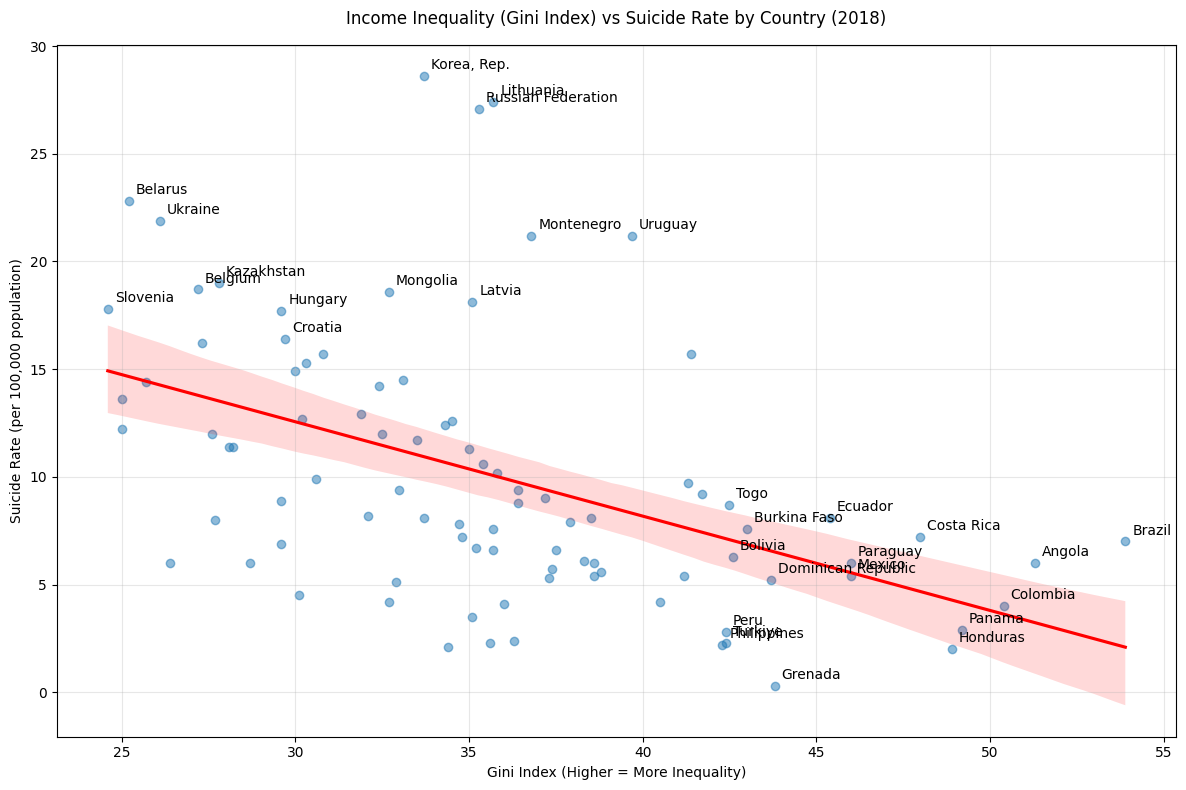

Summary:

The claim "Income inequality causes suicides" is not supported by the available data. In fact, the analysis shows:

1. A moderate negative correlation (-0.47) between income inequality (GINI index) and suicide rates across 91 countries in 2018
2. This means countries with higher income inequality tend to have lower suicide rates, contrary to the original claim
3. The average GINI index was 35.68, with an average suicide rate of 10.07 per 100,000 population

Important caveats:
- Correlation does not imply causation
- The analysis only covers one year (2018)
- Only 91 countries had data for both metrics, which may not be representative of all nations
- Other socioeconomic factors not included in this analysis could influence suicide rates

The data suggests the relationship between income inequality and suicide rates is more complex than the original claim implies, and may even run counter to the stated assumption.
=== Step 2: Looking for data about for: "[Which country] is the

## "[Which country] is the most forested large country"

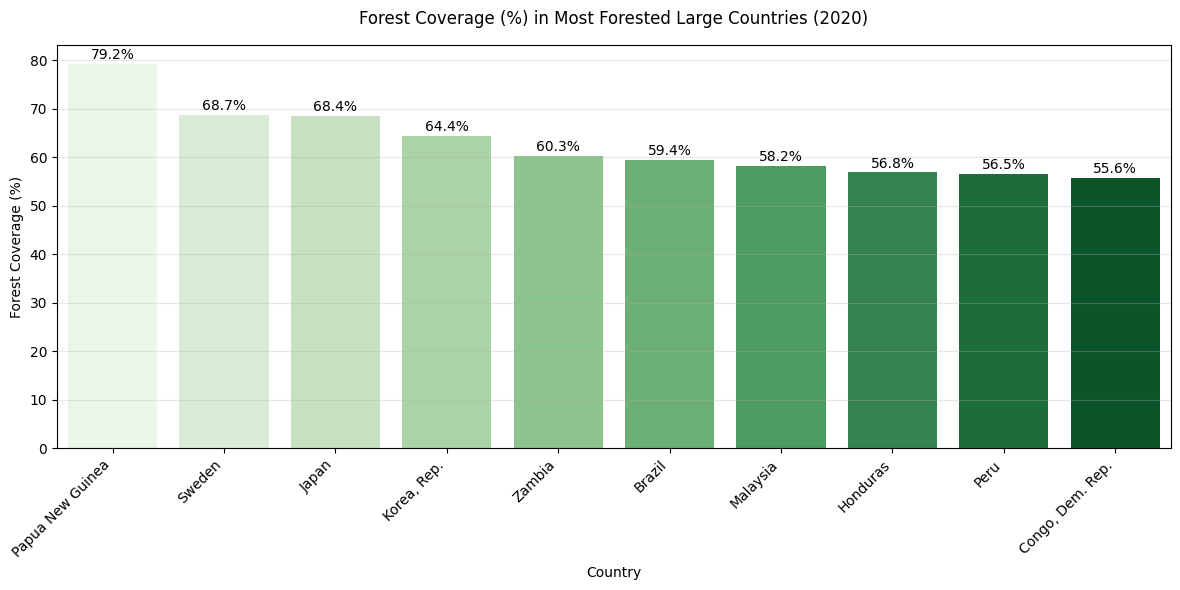

Based on the analysis, I can provide a fact-check regarding the most forested large country:

Among countries with populations over 10 million, Papua New Guinea has the highest forest coverage at 79.2% of its land area (as of 2020). This places it at the top of large nations in terms of forest percentage.

Key context:
- The analysis only includes countries with populations exceeding 10 million (as of 2023)
- Forest coverage data is from 2020
- The top 10 most forested large countries average 62.8% forest coverage
- The analysis covers countries with a combined population of 614.4 million

Caveat: This analysis only considers percentage of land covered by forest, not total forest area. A country could have a lower percentage but larger total forest area due to its size.


In [47]:
FactCheckAgent(model=CLAUDE, verbose=False).process_text('''
Income inequality causes suicides.
Most text is not relevant for fact checking. It will be ignored. Lorem ipsum.
What is the most forested large country?
''');

=== Step 0: Extracting article text
=== Step 1: Extracting snippets ===
  - "China's economy rebounded in the last three months of last year, allowing the government to meet its growth target of 5% in 2024"
  - "it is one of the slowest rates of growth in decades [in China]"
  - "household consumption contributed just 29% to China's economic activity, down from 59% before the pandemic [in China]"
  - "the property market accounted for almost a third of China's economy"
  - "China overtook Japan as the world's biggest car exporter"
  - "there were more than 900 protests in China between June and September 2024 led by workers and property owners - 27% more than the same period a year earlier"
  - "youth jobless rate remains high compared to before the pandemic [in China]"
=== Step 2: Looking for data about for: "China's economy rebounded in the last three months of last year, allowing the government to meet its growth target of 5% in 2024" ===
Downloading: 100%|██████████|
=== Step 3: An

## "it is one of the slowest rates of growth in decades [in China]"

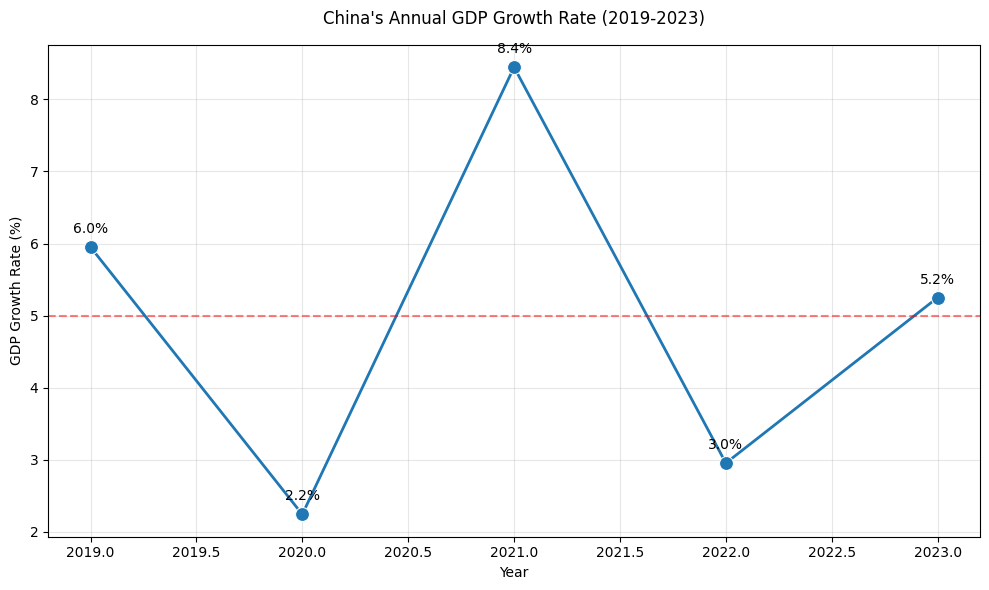

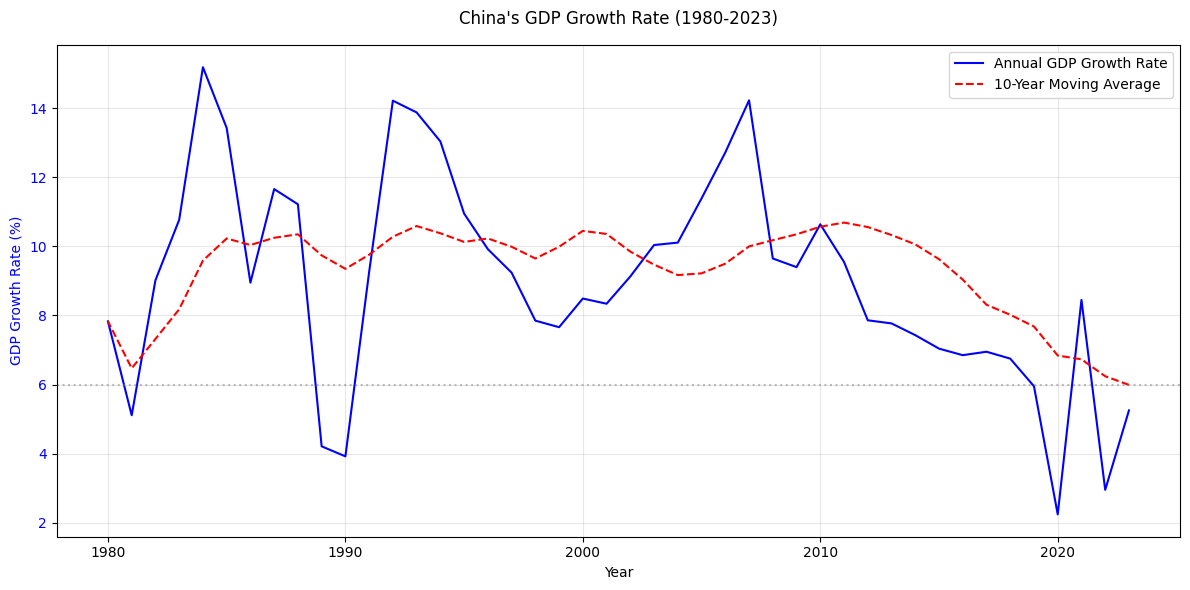

CLAIM ASSESSMENT: The claim about China's growth being "one of the slowest rates in decades" is accurate with important context.

KEY FINDINGS:
- China's latest GDP growth rate is 5.25%
- This is significantly lower than historical averages:
  * 1980-2010 average: 10.05%
  * 2011-2023 average: 6.54%
- The absolute lowest growth since 1980 was 2.24% in 2020 (during COVID-19)
- Current 10-year moving average is 5.99%

CONTEXT:
While the current growth rate of 5.25% is much lower than China's historical double-digit growth periods, it's not at historic lows. The current rate represents a structural slowdown from China's previous high-growth era, but remains above the 2020 pandemic-induced low.

CAVEAT:
The data spans 1980-2023, so "decades" can be properly assessed within this timeframe.
=== Step 2: Looking for data about for: "household consumption contributed just 29% to China's economic activity, down from 59% before the pandemic [in China]" ===
No suitable data available: SELECT 
    

[{'snippet': '"it is one of the slowest rates of growth in decades [in China]"',
  'sql_query': "WITH china_growth AS (\n  SELECT year, value\n  FROM hungerundwurst.world_bank.indicators\n  WHERE country_name = 'China'\n  AND indicator_code = 'NY.GDP.MKTP.KD.ZG'\n  AND year >= 1980\n  AND year <= 2023\n  ORDER BY year DESC\n)\nSELECT \n  year,\n  ROUND(value, 2) as gdp_growth_rate,\n  ROUND(AVG(value) OVER (ORDER BY year ROWS BETWEEN 9 PRECEDING AND CURRENT ROW), 2) as ten_year_moving_avg\nFROM china_growth\nORDER BY year DESC;",
  'data':     year  gdp_growth_rate  ten_year_moving_avg
  0   2023             5.25                 5.99
  1   2022             2.95                 6.24
  2   2021             8.45                 6.73
  3   2020             2.24                 6.84
  4   2019             5.95                 7.68
  5   2018             6.75                 8.02
  6   2017             6.95                 8.31
  7   2016             6.85                 9.04
  8   2015     

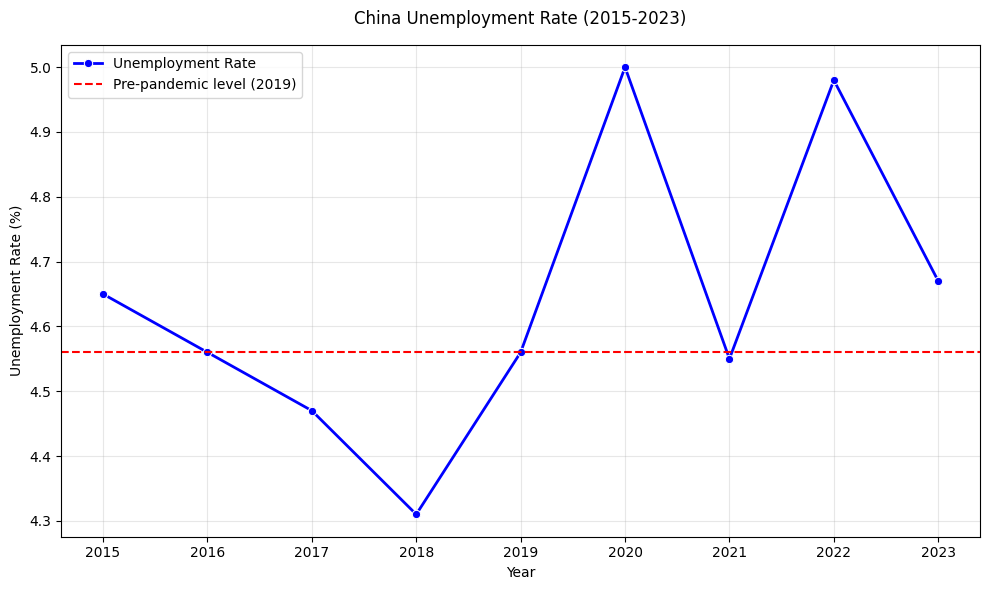

In [14]:
FactCheckAgent(model=CLAUDE, verbose=False).process_text('https://www.bbc.co.uk/news/articles/ceq9lxlg811o')